In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import (
    DateRange,
    Dimension,
    Metric,
    RunReportRequest,
    OrderBy,
)

In [3]:
## Set up global variables

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'service_account.json'
property_id = '468166589'

client = BetaAnalyticsDataClient()

In [11]:
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="date"), ],
        metrics=[Metric(name="newUsers")],
        date_ranges=[DateRange(start_date="2024-12-01", end_date="2025-01-31")],
    )

# Fetch the response
response = client.run_report(request)


In [15]:
# Convert response to DataFrame
data = []
for row in response.rows:
    data.append([row.dimension_values[0].value, int(row.metric_values[0].value)])

df = pd.DataFrame(data, columns=["date", "newUsers"])
df["date"] = pd.to_datetime(df["date"])  # Convert to datetime format
df.set_index("date", inplace=True)  # Set date as index

print(df.head())

            newUsers
date                
2024-12-13       890
2024-12-14       855
2024-12-18       850
2025-01-30       840
2024-12-15       838


In [24]:
import numpy as np

# Calculate Z-score
df["z_score"] = (df["newUsers"] - df["newUsers"].mean()) / df["newUsers"].std()

# Define anomaly threshold (e.g., Z > 3 or Z < -3)
threshold = 3
df["anomaly_z"] = df["z_score"].apply(lambda x: "Anomaly" if abs(x) > threshold else "Normal")

# Print anomalies
print(df[df["anomaly_z"] == "Anomaly"])



Empty DataFrame
Columns: [newUsers, z_score, anomaly_z, anomaly_iforest]
Index: []


In [17]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination level as needed
df["anomaly_iforest"] = model.fit_predict(df[["newUsers"]])

# Convert results: -1 means anomaly, 1 means normal
df["anomaly_iforest"] = df["anomaly_iforest"].apply(lambda x: "Anomaly" if x == -1 else "Normal")

# Print anomalies
print(df[df["anomaly_iforest"] == "Anomaly"])

            newUsers   z_score anomaly_z anomaly_iforest
date                                                    
2024-12-13       890  1.927737    Normal         Anomaly
2025-01-22       238 -1.420642    Normal         Anomaly
2024-12-29       170 -1.769860    Normal         Anomaly
2024-12-28       147 -1.887977    Normal         Anomaly


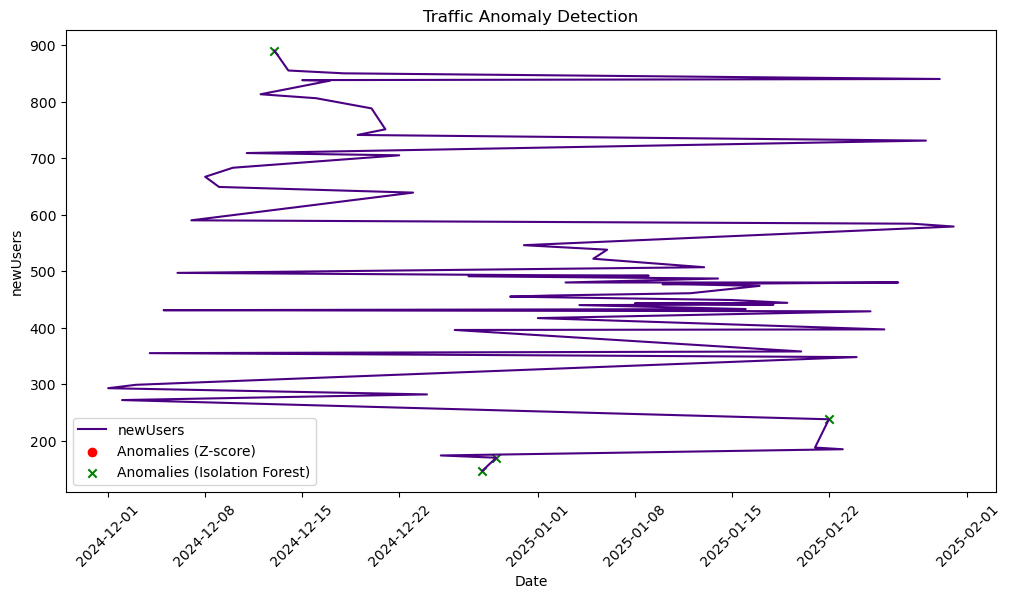

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["newUsers"], label="newUsers", color="indigo")

# Plot anomalies detected by Z-score
anomalies = df[df["anomaly_z"] == "Anomaly"]
plt.scatter(anomalies.index, anomalies["newUsers"], color="red", label="Anomalies (Z-score)", marker="o")

# Plot anomalies detected by Isolation Forest
anomalies_if = df[df["anomaly_iforest"] == "Anomaly"]
plt.scatter(anomalies_if.index, anomalies_if["newUsers"], color="green", label="Anomalies (Isolation Forest)", marker="x")

plt.xlabel("Date")
plt.ylabel("newUsers")
plt.title("Traffic Anomaly Detection")
plt.legend()
plt.xticks(rotation=45)
plt.show()